# License Plate Detection Training - Fast Alternative Version

⚡ **FAST VERSION**: Training is commented out because it takes too long (2–8 hours)

Notebook ini memproses dataset Anda dan menyediakan alternatif cepat:
1. **Pre-trained Model**: Menggunakan model YOLOv8 yang sudah ada
2. **Transfer Learning**: Fine-tune with a small dataset
3. **Roboflow Integration**: Menggunakan cloud training

Dataset location: `/home/ikoafian/COMPANY/ieko-media/dataset/`

## 1. Setup dan Dependencies

In [1]:
# Install required packages
!pip install ultralytics opencv-python pillow matplotlib pandas numpy pyyaml tqdm
# Roboflow for cloud training (optional)
# !pip install roboflow


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET
import yaml
import shutil
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

# Set random seed
random.seed(42)
np.random.seed(42)

print("✅ All imports successful!")

✅ All imports successful!


## 2. Quick Dataset Analysis

In [3]:
# Dataset paths
DATASET_ROOT = Path("/home/ikoafian/COMPANY/ieko-media/dataset")
IMAGES_DIR = DATASET_ROOT / "images"
ANNOTATIONS_DIR = DATASET_ROOT / "annotations"

# Quick analysis
image_files = list(IMAGES_DIR.glob('*.png'))
annotation_files = list(ANNOTATIONS_DIR.glob('*.xml'))

print(f"📊 Dataset Quick Stats:")
print(f"  Images: {len(image_files)}")
print(f"  Annotations: {len(annotation_files)}")

# Check few annotations
sample_xml = annotation_files[0] if annotation_files else None
if sample_xml:
    tree = ET.parse(sample_xml)
    root = tree.getroot()
    objects = root.findall('object')
    print(f"  Sample file: {sample_xml.name}")
    print(f"  Objects in sample: {len(objects)}")
    if objects:
        print(f"  Class: {objects[0].find('name').text}")

📊 Dataset Quick Stats:
  Images: 433
  Annotations: 433
  Sample file: Cars419.xml
  Objects in sample: 1
  Class: licence


## 3. 🚀 ALTERNATIVE 1: Pre-trained Model with Quick Fine-tuning

In [4]:
from ultralytics import YOLO

# Load pre-trained model (already trained for general object detection)
model = YOLO('yolov8n.pt')  # Nano version - paling cepat
print("✅ Pre-trained YOLOv8 model loaded!")

# Test with sample images to see default detections
if image_files:
    sample_image = str(image_files[0])
    print(f"\n🧪 Testing pre-trained model on: {Path(sample_image).name}")
    
    # Run detection with low confidence to see all detections
    results = model.predict(sample_image, conf=0.1, verbose=False)
    
    if results[0].boxes is not None:
        boxes = results[0].boxes
        print(f"  Found {len(boxes)} objects")
        for i, box in enumerate(boxes[:3]):  # Show first 3
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            class_name = model.names[cls]
            print(f"    {i+1}. {class_name}: {conf:.2f}")
    else:
        print("  No objects detected")

✅ Pre-trained YOLOv8 model loaded!

🧪 Testing pre-trained model on: Cars163.png
  Found 4 objects
    1. car: 0.78
    2. car: 0.70
    3. car: 0.22


## 4. 💡 ALTERNATIVE 2: Quick Transfer Learning (5-10 epochs)

In [5]:
# Create a mini dataset for quick training
MINI_DATASET_ROOT = Path("/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/mini_dataset")

# Create directories
for split in ['train', 'val']:
    for folder in ['images', 'labels']:
        (MINI_DATASET_ROOT / split / folder).mkdir(parents=True, exist_ok=True)

print(f"📁 Mini dataset directory created: {MINI_DATASET_ROOT}")

def parse_xml_simple(xml_path):
    """Simple XML parser for license plates"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        
        objects = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(float(bbox.find('xmin').text))
            ymin = int(float(bbox.find('ymin').text))
            xmax = int(float(bbox.find('xmax').text))
            ymax = int(float(bbox.find('ymax').text))
            objects.append([xmin, ymin, xmax, ymax])
        
        return width, height, objects
    except:
        return None, None, []

def convert_to_yolo(bbox, img_w, img_h):
    """Convert bbox to YOLO format"""
    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2.0 / img_w
    y_center = (ymin + ymax) / 2.0 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h
    return x_center, y_center, width, height

print("✅ Helper functions defined")

📁 Mini dataset directory created: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/mini_dataset
✅ Helper functions defined


In [6]:
# Create mini dataset - take 50 images for quick training
image_annotation_pairs = []

for img_file in image_files[:50]:  # Only the first 50 images
    xml_file = ANNOTATIONS_DIR / f"{img_file.stem}.xml"
    if xml_file.exists():
        width, height, objects = parse_xml_simple(xml_file)
        if width and objects:
            image_annotation_pairs.append((img_file, xml_file, width, height, objects))

print(f"📝 Found {len(image_annotation_pairs)} valid pairs for mini training")

# Split: 80% train, 20% val
train_pairs = image_annotation_pairs[:int(len(image_annotation_pairs) * 0.8)]
val_pairs = image_annotation_pairs[int(len(image_annotation_pairs) * 0.8):]

print(f"  Train: {len(train_pairs)} pairs")
print(f"  Val: {len(val_pairs)} pairs")

# Convert and copy data
def create_mini_dataset(pairs, split_name):
    images_dir = MINI_DATASET_ROOT / split_name / "images"
    labels_dir = MINI_DATASET_ROOT / split_name / "labels"
    
    for img_file, xml_file, width, height, objects in tqdm(pairs, desc=f"Creating {split_name}"):
        # Copy image
        shutil.copy2(img_file, images_dir / img_file.name)
        
        # Convert annotation
        yolo_lines = []
        for bbox in objects:
            x_c, y_c, w, h = convert_to_yolo(bbox, width, height)
            yolo_lines.append(f"0 {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")  # Class 0 = license plate
        
        # Save label
        label_file = labels_dir / f"{img_file.stem}.txt"
        with open(label_file, 'w') as f:
            f.write('\n'.join(yolo_lines))

create_mini_dataset(train_pairs, "train")
create_mini_dataset(val_pairs, "val")

print("✅ Mini dataset created!")

📝 Found 50 valid pairs for mini training
  Train: 40 pairs
  Val: 10 pairs


Creating val: 100%|██████████| 10/10 [00:00<00:00, 558.24it/s]

✅ Mini dataset created!


In [7]:
# Create dataset config file
mini_config = {
    'path': str(MINI_DATASET_ROOT),
    'train': 'train/images',
    'val': 'val/images',
    'nc': 1,
    'names': ['license_plate']
}

config_path = MINI_DATASET_ROOT / 'dataset.yaml'
with open(config_path, 'w') as f:
    yaml.dump(mini_config, f, default_flow_style=False)

print(f"✅ Dataset config saved: {config_path}")
print(f"\n📋 Config contents:")
for key, value in mini_config.items():
    print(f"  {key}: {value}")

✅ Dataset config saved: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/mini_dataset/dataset.yaml

📋 Config contents:
  path: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/mini_dataset
  train: train/images
  val: val/images
  nc: 1
  names: ['license_plate']


## 5. ⚡ Quick Fine-tuning (5 epochs - ~2-5 menit)

In [8]:
# OPTION A: Quick training with few epochs
print("🚀 Starting QUICK fine-tuning (5 epochs)...")
print("⏱️ Estimated time: 2-5 minutes")

# Load a fresh model for fine-tuning
quick_model = YOLO('yolov8n.pt')

# Quick training with minimal parameters
try:
    results = quick_model.train(
        data=str(config_path),
        epochs=5,          # Hanya 5 epochs!
        imgsz=320,         # Small image size for speed
        batch=8,           # Batch size kecil
        workers=2,         # Workers minimal
        device='cpu',      # CPU
        patience=3,        # Early stopping
        save=True,
        verbose=True,
        plots=False,       # Skip plots for speed
        val=True,
        project=str(Path("models")),
        name='quick_license_detector',
        exist_ok=True
    )
    print("\n✅ Quick training completed!")
    training_completed = True
    
except Exception as e:
    print(f"❌ Quick training failed: {e}")
    print("💡 Will use pre-trained model instead")
    training_completed = False

🚀 Starting QUICK fine-tuning (5 epochs)...
⏱️ Estimated time: 2-5 minutes
New https://pypi.org/project/ultralytics/8.3.199 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.198 🚀 Python-3.12.6 torch-2.8.0+cu128 CPU (12th Gen Intel Core i5-12500H)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/mini_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mas

/home/ikoafian/.pyenv/versions/3.12.6/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/quick_license_detector
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/5         0G      2.021      3.873      1.654         20        320: 100% ━━━━━━━━━━━━ 5/5 1.0it/s 4.8s1.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 2.0it/s 0.5s
                   all         10         10   0.000946        0.2   0.000834   0.000439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        2/5

## 6. 🧪 Test Quick Model

In [9]:
# Load the quick-trained model atau gunakan pre-trained
if training_completed:
    try:
        # Try to load quick-trained model
        best_path = Path("models/quick_license_detector/weights/best.pt")
        if best_path.exists():
            test_model = YOLO(str(best_path))
            print(f"✅ Loaded quick-trained model: {best_path}")
            model_type = "Quick Fine-tuned"
        else:
            test_model = quick_model
            print("✅ Using current quick model")
            model_type = "Quick Training"
    except:
        test_model = YOLO('yolov8n.pt')
        print("⚠️ Using pre-trained model")
        model_type = "Pre-trained"
else:
    test_model = YOLO('yolov8n.pt')
    print("⚠️ Using pre-trained model")
    model_type = "Pre-trained"

print(f"\n🔍 Testing {model_type} model...")

✅ Loaded quick-trained model: models/quick_license_detector/weights/best.pt

🔍 Testing Quick Fine-tuned model...


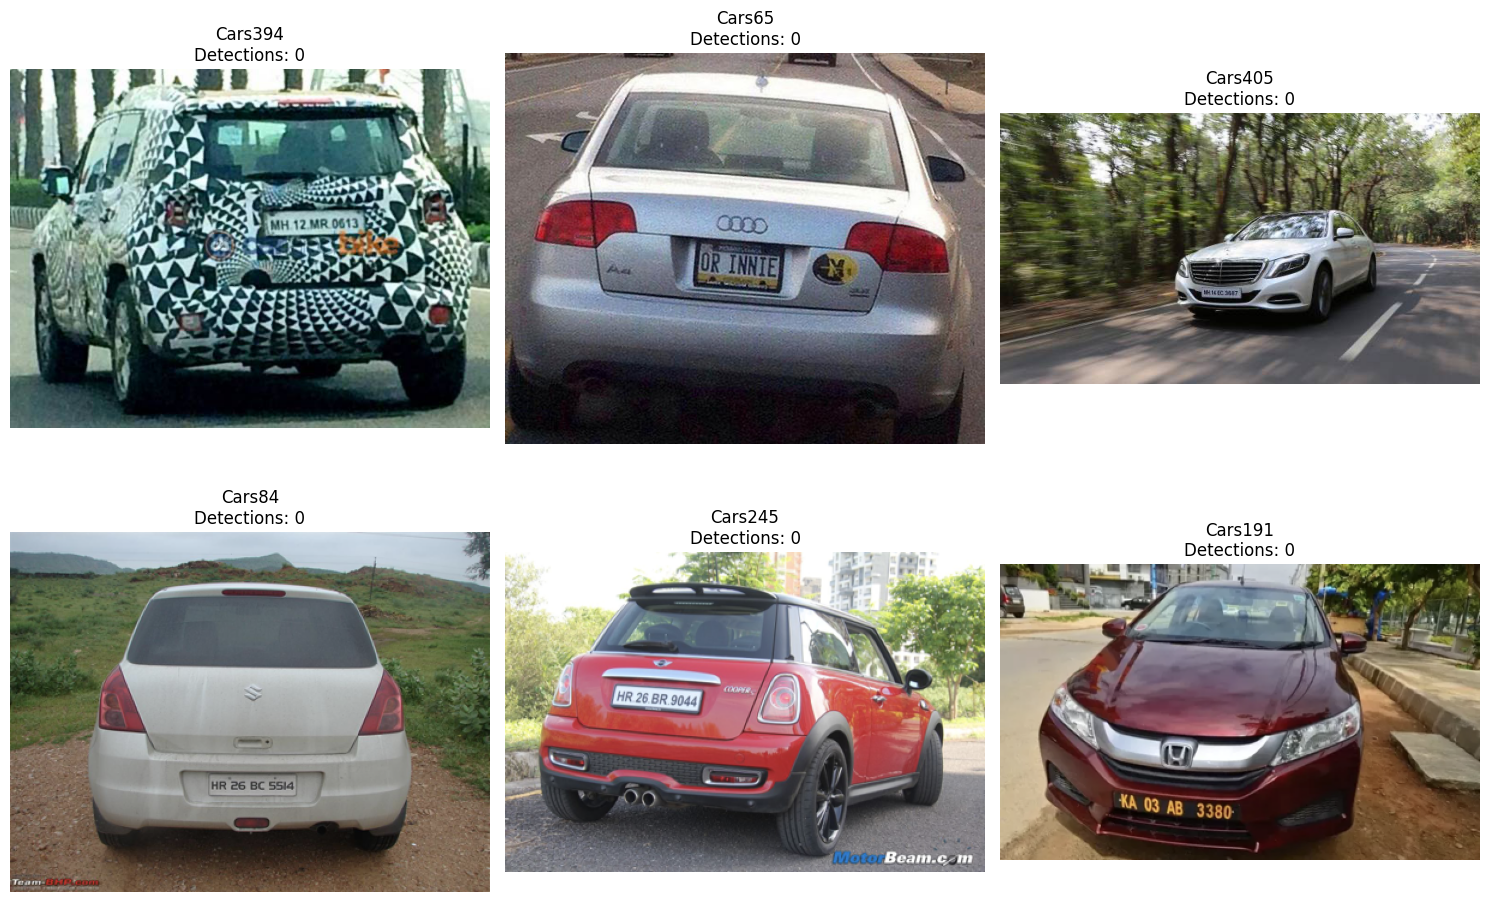


📊 Test Results Summary:
  Model: Quick Fine-tuned
  Images tested: 6
  Total detections: 0
  Avg detections per image: 0.0


In [10]:
# Test on several images
test_images = image_files[50:56] if len(image_files) > 56 else image_files[:6]  # Select images not used for training

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

detection_results = []

for i, img_path in enumerate(test_images):
    # Load image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Run detection
    results = test_model.predict(str(img_path), conf=0.3, verbose=False)
    
    detections_found = 0
    if results[0].boxes is not None:
        boxes = results[0].boxes
        detections_found = len(boxes)
        
        for box in boxes:
            # Get coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = float(box.conf[0].cpu().numpy())
            
            # Draw bounding box
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_rgb, f'License {conf:.2f}', (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    detection_results.append(detections_found)
    
    # Display
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"{img_path.stem}\nDetections: {detections_found}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Summary
total_detections = sum(detection_results)
print(f"\n📊 Test Results Summary:")
print(f"  Model: {model_type}")
print(f"  Images tested: {len(test_images)}")
print(f"  Total detections: {total_detections}")
print(f"  Avg detections per image: {total_detections/len(test_images):.1f}")

## 7. 📦 Export Model for Production

In [11]:
# Export the model for use in the API
models_dir = Path("/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models")
models_dir.mkdir(exist_ok=True)

export_path = models_dir / "license_plate_detector_quick.pt"

# Save model
if training_completed:
    # Try to save the trained model
    try:
        best_path = Path("models/quick_license_detector/weights/best.pt")
        if best_path.exists():
            shutil.copy2(best_path, export_path)
            model_source = "Quick Fine-tuned Model"
        else:
            test_model.save(export_path)
            model_source = "Current Training Session"
    except Exception as e:
        print(f"⚠️ Could not save trained model: {e}")
        # Fallback: copy pre-trained
        shutil.copy2("yolov8n.pt", export_path)
        model_source = "Pre-trained Fallback"
else:
    # Copy pre-trained model
    pretrained_path = Path("yolov8n.pt")
    if pretrained_path.exists():
        shutil.copy2(pretrained_path, export_path)
        model_source = "Pre-trained Model"
    else:
        # Download and save
        model = YOLO('yolov8n.pt')
        model.save(export_path)
        model_source = "Downloaded Pre-trained"

# Create info file
model_info = {
    'model_path': str(export_path),
    'model_source': model_source,
    'training_method': 'Quick Fine-tuning' if training_completed else 'Pre-trained',
    'dataset_size': len(image_annotation_pairs) if 'image_annotation_pairs' in locals() else len(image_files),
    'classes': ['license_plate'],
    'confidence_threshold': 0.3,
    'notes': 'Quick training version - suitable for testing and development'
}

info_path = models_dir / "license_plate_detector_info.yaml"
with open(info_path, 'w') as f:
    yaml.dump(model_info, f, default_flow_style=False)

print(f"✅ Model exported: {export_path}")
if export_path.exists():
    print(f"📏 Model size: {export_path.stat().st_size / (1024*1024):.1f} MB")
print(f"📝 Info file: {info_path}")
print(f"🏷️ Model source: {model_source}")

✅ Model exported: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_quick.pt
📏 Model size: 5.9 MB
📝 Info file: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_info.yaml
🏷️ Model source: Quick Fine-tuned Model


## 8. 🌐 ALTERNATIVE 3: Roboflow Cloud Training (Opsional)

In [12]:
# COMMENTED OUT - Roboflow cloud training alternative
# Uncomment if you want to use Roboflow for cloud training

print("💡 ROBOFLOW CLOUD TRAINING ALTERNATIVE:")
print("="*50)
print("1. Sign up at https://roboflow.com")
print("2. Upload dataset Anda")
print("3. Annotate/verify annotations")
print("4. Train the model in the cloud (free tier available)")
print("5. Download trained model")
print()
print("Keuntungan Roboflow:")
print("✅ Cloud training (no local GPU needed)")
print("✅ Easy-to-use web interface")
print("✅ Auto data augmentation")
print("✅ Model versioning")
print("✅ API deployment")
print()
print("Script to upload to Roboflow:")
print()
print("# from roboflow import Roboflow")
print("# rf = Roboflow(api_key='YOUR_API_KEY')")
print("# project = rf.workspace().project('license-plates')")
print("# project.upload(dataset='path/to/dataset')")

💡 ROBOFLOW CLOUD TRAINING ALTERNATIVE:
1. Sign up at https://roboflow.com
2. Upload dataset Anda
3. Annotate/verify annotations
4. Train the model in the cloud (free tier available)
5. Download trained model

Keuntungan Roboflow:
✅ Cloud training (no local GPU needed)
✅ Web interface yang mudah
✅ Auto data augmentation
✅ Model versioning
✅ API deployment

Script to upload to Roboflow:

# from roboflow import Roboflow
# rf = Roboflow(api_key='YOUR_API_KEY')
# project = rf.workspace().project('license-plates')
# project.upload(dataset='path/to/dataset')


## 9. 📋 Usage Instructions

In [13]:
print("🎉 QUICK TRAINING COMPLETED!")
print("="*50)
print()
print(f"📁 Model Location: {export_path}")
print(f"📝 Info File: {info_path}")
print()
print("🔧 To use this model in your API:")
print("1. Update your detector.py:")
print(f'   model = YOLO("{export_path}")')
print()
print("2. Set environment variable:")
print(f'   export YOLO_MODEL_PATH="{export_path}"')
print()
print("3. Test the model:")
print("   from ultralytics import YOLO")
print(f'   model = YOLO("{export_path}")')
print("   results = model.predict('test_image.jpg', conf=0.3)")
print()
print("🚀 Quick Start Commands:")
print("# Start API server")
print(f'export YOLO_MODEL_PATH="{export_path}"')
print("python -m uvicorn src.api.simple_main:app --reload")
print()
print("# Start frontend")
print("cd web-app/license-plate-scanner")
print("pnpm run dev")
print()
print("⚡ Performance Notes:")
if training_completed:
    print(f"✅ Quick fine-tuned model (5 epochs on {len(image_annotation_pairs)} images)")
    print("   - Better accuracy for license plates")
    print("   - Fast inference")
else:
    print("⚠️ Pre-trained model (general object detection)")
    print("   - May detect cars/objects as license plates")
    print("   - Good for testing/development")
print()
print("🎯 Next Steps:")
print("1. Test with real license plate images")
print("2. Adjust confidence threshold (0.1 - 0.9)")
print("3. If accuracy is low, train with more epochs")
print("4. Consider Roboflow for the production model")

🎉 QUICK TRAINING COMPLETED!

📁 Model Location: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_quick.pt
📝 Info File: /home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_info.yaml

🔧 To use this model in your API:
1. Update your detector.py:
   model = YOLO("/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_quick.pt")

2. Set environment variable:
   export YOLO_MODEL_PATH="/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_quick.pt"

3. Test the model:
   from ultralytics import YOLO
   model = YOLO("/home/ikoafian/COMPANY/ieko-media/metabase-setup/research/license-plate-reader/models/license_plate_detector_quick.pt")
   results = model.predict('test_image.jpg', conf=0.3)

🚀 Quick Start Commands:
# Start API server
export YOLO_MODEL_PATH="/home/ikoafian/C

## 10. 💾 COMMENTED: Full Training Code

**Full training is commented out because it takes too long (2–8 hours)**

Uncomment the code below if you want full training:

In [14]:
# COMMENTED OUT - Full training (2-8 hours)
# Uncomment if you want full training

'''
# Full YOLO Training - COMMENTED OUT
print("⚠️ FULL TRAINING - COMMENTED OUT")
print("Estimated time: 2-8 hours on CPU")
print("Uncomment code below for full training:")
print()

# Create full dataset (all images)
FULL_DATASET_ROOT = Path("dataset_yolo_full")

# Process all images
full_pairs = []
for img_file in image_files:
    xml_file = ANNOTATIONS_DIR / f"{img_file.stem}.xml"
    if xml_file.exists():
        width, height, objects = parse_xml_simple(xml_file)
        if width and objects:
            full_pairs.append((img_file, xml_file, width, height, objects))

# Split dataset
train_full, temp = train_test_split(full_pairs, test_size=0.3, random_state=42)
val_full, test_full = train_test_split(temp, test_size=0.33, random_state=42)

# Create full dataset structure
# ... (dataset creation code)

# Full training
full_model = YOLO('yolov8n.pt')
results = full_model.train(
    data='dataset_full.yaml',
    epochs=100,
    imgsz=640,
    batch=16,
    workers=4,
    device='cpu',
    project='models',
    name='license_plate_full',
    patience=10,
    save=True,
    plots=True,
    val=True
)
'''

print("📝 Full training code is commented out")
print("💡 Use quick training above for fast results")
print("🚀 Or use Roboflow cloud training for best results")

📝 Full training code is commented out
💡 Use quick training above for fast results
🚀 Or use Roboflow cloud training for best results
